### Building a Vision Transformer from Scratch in PyTorch

- A Vision Transformer (ViT) is a deep learning architecture designed to apply transformers to computer vision tasks. 
- Traditionally, convolutional neural networks (CNNs) have been the dominant model for vision-based applications, but ViTs offer a novel approach. 
- Instead of using convolutions to process images, ViTs split an image into smaller patches and treat each patch as a token (similar to words in NLP), feeding them into a transformer model. 
- The ViT model captures long-range dependencies in an image, making it particularly effective for tasks like image classification.




#### Key Concepts Behind Vision Transformers:

- <b>Patch Embedding:</b> Instead of processing the entire image at once, Vision Transformers divide an image into non-overlapping patches and embed them into a lower-dimensional space.
- <b>Positional Encoding:</b> Since transformers are permutation-invariant, positional information is crucial for them to understand spatial relationships between image patches.
- <b>Multi-Head Self-Attention: <b/> This mechanism allows the model to attend to multiple patches at once, capturing both local and global dependencies.
- <b>Feed-Forward Network:</b> A multi-layer perceptron (MLP) processes the attention-weighted patches to generate the final output.

#### Why Use Transformers for Vision Tasks?

<a href ="https://www.geeksforgeeks.org/machine-learning/getting-started-with-transformers/"> Transformers </a> have proven highly effective in natural language processing (NLP), particularly in tasks requiring attention mechanisms. By applying transformers to vision tasks, we can overcome some of the limitations of CNNs:

 - <b> Global Attention: </b> Transformers excel at capturing global dependencies through self-attention, allowing them to focus on the entire image rather than just local regions, as CNNs do.
 - <b> Scalability: </b> Vision Transformers are highly scalable, performing well when pre-trained on large datasets (e.g., ImageNet).
 - <b> Fewer Inductive Biases: </b> Unlike CNNs, which rely heavily on the locality of pixels, transformers make fewer assumptions about the input, potentially learning more complex relationships in the data.

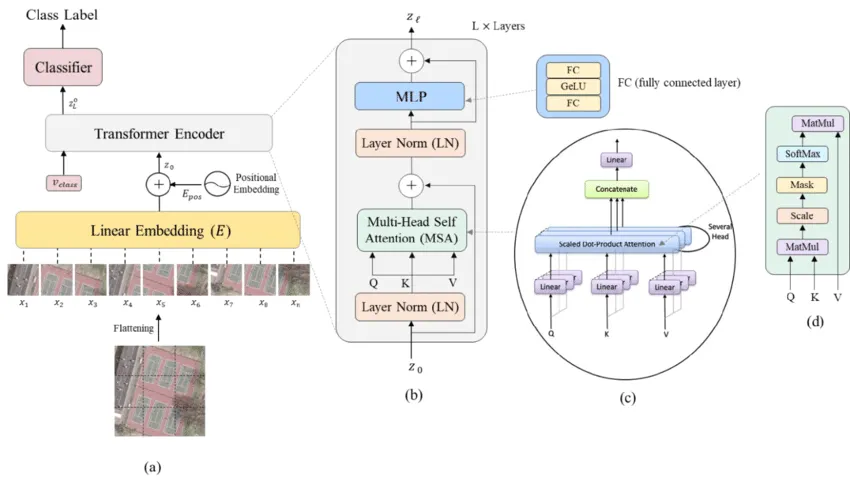

The architecture of the ViT with specific details on the transformer encoder and the MSA block.  Picture from <a href = "https://www.researchgate.net/publication/348947034_Vision_Transformers_for_Remote_Sensing_Image_Classification" > Bazi et. al. </a>

#### Building the vision transformer from scratch

We will implement the vision transformers using Pytorch, including patch embedding, transformer encoder blocks, positional encoding, multihead attention. For this experiment, we will use the <a href = "https://www.geeksforgeeks.org/machine-learning/cifar-100-dataset/#what-is-the-cifar100-dataset"> cifar-10 dataset</a>. Let's start it.

#### 1. Divide into patches

Vision Transformers first divide an image into fixed-size patches. Each patch is flattened into a vector, which is then embedded using a linear projection.

In [ ]:
import torch 
import torch.nn as nn

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B, embed_dim, H/patch_size, W/patch_size) -> (B, embed_dim, N) -> (B, N, embed_dim)
        return x



## Patch Embedding Explained Simply

**Starting Point: One 224×224 Image**

You have a single image that is 224 pixels wide and 224 pixels tall. That's 50,176 total pixels.

**Step 1: Cut the Image into Patches**

Instead of feeding the entire image to the transformer, we cut it into small square pieces. Each piece is 16×16 pixels.

How many pieces do we get?
- Horizontally: 224 ÷ 16 = 14 patches
- Vertically: 224 ÷ 16 = 14 patches
- Total: 14 × 14 = **196 patches**

Think of it like cutting a photo into a 14×14 grid of tiles.

**Step 2: Each Patch Has Color Information**

Each 16×16 patch contains 3 color channels (Red, Green, Blue).

So each patch has: 16 × 16 × 3 = **768 values**

**Step 3: Convert Each Patch to an Embedding**

The Conv2d layer is like a "compression machine." It takes those 768 pixel values from each patch and compresses them into a single **768-dimensional vector** (768 numbers).

Think of it as creating a "fingerprint" or "summary" of each patch. These 768 numbers represent what that patch looks like in a learned way.

**Step 4: Stack All Patches Together**

Now you have:
- 196 patches (from the 14×14 grid)
- Each patch is represented as 768 numbers
- Stacked together in order

**Final Output: (1, 196, 768)**

- **1** = You're processing 1 image (batch size)
- **196** = 196 patches from that image
- **768** = Each patch is a 768-dimensional vector

So you've transformed one 224×224 image into a sequence of 196 vectors, each with 768 values.

**Why Do This?**

Transformers work with sequences (like sentences in NLP). By converting an image into 196 "patches" (like 196 words), the transformer can process images the same way it processes text.

**Simple Analogy:**

Imagine you have a photo of a cat. You cut it into 196 pieces. Then for each piece, you write down 768 important features (is it fuzzy? is it orange? does it have an eye?). You stack all 196 pieces of information. Now a transformer can read through these 196 descriptions and understand the whole cat.

# PatchEmbedding Code Breakdown

## Class Definition
```python
class PatchEmbedding(nn.Module):
```
- Creates a new neural network module called `PatchEmbedding`
- Inherits from `nn.Module` (PyTorch's base class for all neural network layers)
- This means it can be trained, moved to GPU, etc.

---

## The `__init__` Method (Initialization)

```python
def __init__(self, img_size = 224, patch_size = 6, in_channels = 3, embed_dim = 768):
```

This defines what parameters the layer needs:
- `img_size = 224`: The image is 224×224 pixels (default value)
- `patch_size = 6`: Each patch is 6×6 pixels (default value)
- `in_channels = 3`: Input has 3 channels (RGB: Red, Green, Blue)
- `embed_dim = 768`: Output vector for each patch is 768 dimensions

---

```python
super().__init__()
```
- Calls the parent class (`nn.Module`) constructor
- Necessary setup for PyTorch modules
- Think of it as "initialize the base layer first"

---

```python
self.img_size = img_size
self.patch_size = patch_size
```
- Stores the image size and patch size as class variables
- We save these because we use them later in the `forward()` method to validate input

---

```python
self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
```

This is the **most important line**. Let me break down `Conv2d`:

### What is Conv2d?

**Conv2d** = 2D Convolution. It's a sliding window operation that applies filters to an image.

**Parameters:**
- `in_channels = 3`: The input has 3 channels (RGB)
- `embed_dim = 768`: We want 768 output filters/channels
- `kernel_size = patch_size = 16`: The window size is 16×16 pixels
- `stride = patch_size = 16`: The window moves 16 pixels at a time

### How Conv2d Works (Step by Step)

Imagine you have a 224×224×3 image and a 16×16×3 window:

```
Position 1: Window at (0,0)
  Takes pixels from [0:16, 0:16, :]
  Multiplies by learned weights
  Outputs one vector of 768 values

Position 2: Window moves 16 pixels right to (16,0)
  Takes pixels from [16:32, 0:16, :]
  Multiplies by learned weights
  Outputs another vector of 768 values

Position 3: Window moves 16 pixels down to (0,16)
  Takes pixels from [0:16, 16:32, :]
  And so on...
```

**Key Point: stride=16 means NO OVERLAP**
- With `stride=16`, patches don't overlap
- This gives us exactly 14×14 = 196 patches

**Kernel vs Stride:**
- **kernel_size**: The size of the window looking at the image
- **stride**: How far the window moves each time

**Why kernel_size = stride = patch_size?**
- This ensures each patch is processed exactly once
- No pixel is used twice, no pixel is skipped

---

## The `forward` Method (Processing Data)

```python
def forward(self, x):
```
- This is called when you do `patch_embedding(img)`
- `x` is the input tensor (the image)

---

```python
B, C, H, W = x.shape
```
- Unpacks the shape of the input tensor
- `B` = Batch size (number of images, typically 1 or 32 or 64)
- `C` = Channels (3 for RGB)
- `H` = Height (224)
- `W` = Width (224)

**Example:**
```
If x.shape = (1, 3, 224, 224)
Then: B=1, C=3, H=224, W=224
```

---

```python
assert H == self.img_size and W == self.img_size, f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})."
```

- **`assert`** = "Stop if this condition is false"
- Checks that the input image is exactly 224×224
- If someone passes a 256×256 image, it will crash with an error message
- This is a safety check

**Example of error:**
```
If you pass a 256×256 image:
AssertionError: Input image size (256*256) doesn't match model (224*224).
```

---

```python
x = self.proj(x).flatten(2).transpose(1, 2)
```

This is the most complex line. Let me break it into 3 parts:

### Part 1: `self.proj(x)` - Apply Conv2d

**Input:** `x` shape is `(B, C, H, W)` = `(1, 3, 224, 224)`

**Conv2d Operation:**
- 768 filters of size 16×16×3
- Stride 16
- Slides across the 224×224 image

**Output shape:** `(B, embed_dim, H/patch_size, W/patch_size)`
= `(1, 768, 14, 14)`

**Explanation:**
- 1 image in batch
- 768 output channels (one value per filter)
- 14×14 spatial dimensions (because 224/16 = 14)
- So we have 14×14 = 196 patches, each with 768 values

---

### Part 2: `.flatten(2)` - Flatten the Spatial Dimensions

**What does flatten(2) do?**
- Flattens starting from dimension 2 onwards
- Keeps dimensions 0 and 1, collapses the rest

**Input shape:** `(1, 768, 14, 14)`

**Output shape:** `(1, 768, 196)`

**Step by step:**
```
Before: (1, 768, 14, 14)
        B  embed  H   W

After:  (1, 768, 196)
        B  embed  H*W
        
Because: 14 × 14 = 196
```

**What happened?**
- The 14×14 spatial grid became a single sequence of 196
- Each position in that sequence has 768 values

---

### Part 3: `.transpose(1, 2)` - Swap Dimensions

**What does transpose(1, 2) do?**
- Swaps dimension 1 and dimension 2

**Input shape:** `(1, 768, 196)`

**Output shape:** `(1, 196, 768)`

**Step by step:**
```
Before: (1, 768, 196)
Swap dimensions 1 and 2:
After:  (1, 196, 768)
```

**Why do we need this?**
- Transformers expect: `(batch, sequence_length, embedding_dim)`
- We have: `(batch, embedding_dim, sequence_length)`
- So we swap to get the right format

---

## The Return Statement

```python
return x
```
- Returns the final tensor of shape `(1, 196, 768)`

---

## Putting It All Together: Shape Transformations

```
Input:                    (1, 3, 224, 224)
After Conv2d:             (1, 768, 14, 14)
After flatten(2):         (1, 768, 196)
After transpose(1, 2):    (1, 196, 768)  ← Final output
```

---
---

## Summary Table

| Concept | What It Does | Example |
|---------|-------------|---------|
| **Conv2d** | Sliding window that extracts patches and compresses them | Window of 16×16 pixels → 768 values |
| **kernel_size** | Size of the sliding window | 16×16 |
| **stride** | How far the window moves each time | 16 (no overlap) |
| **flatten(2)** | Collapses spatial dimensions into a sequence | (1, 768, 14, 14) → (1, 768, 196) |
| **transpose(1, 2)** | Swaps two dimensions | (1, 768, 196) → (1, 196, 768) |

---

## Real-World Analogy

Imagine you have a 224×224 photo:

1. **Conv2d (kernel_size=16, stride=16)**: Cut the photo into 196 non-overlapping 16×16 pieces. For each piece, use a "magic filter" that summarizes it into 768 numbers.

2. **flatten(2)**: Stack all 196 pieces in a line.

3. **transpose(1, 2)**: Rearrange so that you have 196 pieces, each with 768 numbers, instead of 768 channels with 196 positions.

4. **Result**: A list of 196 patch embeddings, ready for a transformer!

# Kernels in Conv2d and CNNs Explained

## What is a Kernel?

A **kernel** (also called a **filter**) is a small matrix of numbers that slides across an image to detect patterns.

Think of it as a **pattern detector** or **feature extractor**.

---

## Simple Visual Example

### A 3×3 Kernel

```
Kernel (Filter):
[  0.5  -0.1   0.2 ]
[ -0.3   0.8  -0.4 ]
[  0.1   0.6   0.3 ]
```

This is a 3×3 grid of numbers. These numbers are **learned** by the neural network during training.

---

## How a Kernel Works: Step-by-Step

### The Sliding Window Process

Imagine you have a small image:

```
Image:
[ 1  2  3  4 ]
[ 5  6  7  8 ]
[ 9  10 11 12]
[ 13 14 15 16]
```

And a 3×3 kernel:

```
Kernel:
[ 0.5  -0.1   0.2 ]
[-0.3   0.8  -0.4 ]
[ 0.1   0.6   0.3 ]
```

### Step 1: Position the kernel at (0,0)

```
Image:                    Kernel:
[1   2   3   4]          [0.5  -0.1   0.2]
[5   6   7   8]    ×     [-0.3  0.8  -0.4]
[9   10  11  12]         [0.1   0.6   0.3]
[13  14  15  16]

Extract the 3×3 region:
[1   2   3 ]
[5   6   7 ]
[9   10  11]
```

### Step 2: Multiply element-wise and sum

```
(1 × 0.5)  + (2 × -0.1) + (3 × 0.2)  +
(5 × -0.3) + (6 × 0.8)  + (7 × -0.4) +
(9 × 0.1)  + (10 × 0.6) + (11 × 0.3)

= 0.5 - 0.2 + 0.6 - 1.5 + 4.8 - 2.8 + 0.9 + 6.0 + 3.3
= 11.6

Output: 11.6
```

This produces **one single number** from the 3×3 region.

### Step 3: Slide the kernel

Move the kernel one position to the right:

```
Image:                    Kernel:
[1   2   3   4]          [0.5  -0.1   0.2]
[5   6   7   8]    ×     [-0.3  0.8  -0.4]
[9   10  11  12]         [0.1   0.6   0.3]
[13  14  15  16]

Extract the 3×3 region:
[2   3   4 ]
[6   7   8 ]
[10  11  12]
```

Repeat the multiply and sum → Get another number

### Step 4: Continue sliding

```
Slide right again:
[3   4   ? ]
[7   8   ? ]
[11  12  ? ]

Then slide down and repeat...
```

Keep sliding until you've covered the entire image.

### Final Output (with stride=1)

All the numbers from each position form a new image:

```
Input Image:          Output (after one kernel):
[1   2   3   4]       [11.6  12.3  13.1]
[5   6   7   8]       [14.2  15.5  16.8]
[9   10  11  12]      [17.3  18.1  19.2]
[13  14  15  16]
```

Notice: The output is smaller! (4×4 input → 3×3 output with 3×3 kernel)

---

## What Does a Kernel Detect?

Different kernels detect different features:

### Example 1: Edge Detection Kernel (Horizontal)

```
Kernel:
[-1  -2  -1]
[ 0   0   0]
[ 1   2   1]
```

This kernel detects horizontal edges (transitions from dark to light horizontally).

### Example 2: Vertical Edge Detection

```
Kernel:
[-1   0   1]
[-2   0   2]
[-1   0   1]
```

This detects vertical edges.

### Example 3: Blur Kernel

```
Kernel (normalized):
[1/9  1/9  1/9]
[1/9  1/9  1/9]
[1/9  1/9  1/9]
```

This blurs the image by averaging nearby pixels.

---

## Key Kernel Parameters

### kernel_size

The size of the sliding window.

```python
nn.Conv2d(in_channels, out_channels, kernel_size=3)
# kernel_size=3 means 3×3 kernel
# kernel_size=5 means 5×5 kernel
```

**Larger kernels:**
- See more of the image at once
- Slower computation
- Capture larger patterns

**Smaller kernels:**
- See less of the image
- Faster computation
- Capture fine details

### stride

How many pixels the kernel moves each time.

```python
nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1)
```

**stride=1 (default):**
```
Move 1 pixel at a time
[X X X]
[X X X]
[X X X]
    ↓ (move 1 pixel right)
  [X X X]
  [X X X]
  [X X X]
```

**stride=2:**
```
Move 2 pixels at a time
[X X X X X]
[X X X X X]
[X X X X X]
    ↓↓ (move 2 pixels right)
    [X X X X X]
    [X X X X X]
    [X X X X X]
```

Larger stride = smaller output image

---

## Multiple Kernels

In practice, Conv2d uses **many kernels**, not just one!

```python
nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
```

This means:
- **64 kernels** (filters), each 3×3
- Each kernel detects different features
- One kernel might detect edges, another colors, another textures

### Output with Multiple Kernels

```
Input: (3, 224, 224)           [3 channels, 224×224 image]
       ↓ Conv2d with 64 kernels
Output: (64, 222, 222)         [64 channels, smaller image]
```

Each of the 64 kernels produces its own output image (called a "channel" or "feature map").

---

## How CNNs Work (The Big Picture)

A **CNN (Convolutional Neural Network)** is a stack of Conv2d layers.

### Example CNN Architecture

```
Input Image: (3, 224, 224)
    ↓ Conv2d(3, 64, kernel_size=3)
Feature Map 1: (64, 222, 222)
    ↓ ReLU (activation function)
    ↓ MaxPool (reduce size)
    ↓ Conv2d(64, 128, kernel_size=3)
Feature Map 2: (128, 110, 110)
    ↓ ReLU
    ↓ MaxPool
    ↓ Conv2d(128, 256, kernel_size=3)
Feature Map 3: (256, 54, 54)
    ↓ Flatten
    ↓ Fully Connected Layer
    ↓ Output (class probabilities)
```

### What Each Layer Learns

- **Layer 1:** Detects simple features (edges, colors)
- **Layer 2:** Detects medium features (shapes, corners)
- **Layer 3:** Detects complex features (eyes, wheels, faces)
- **Later layers:** Combine features to make predictions

---

## Conv2d in Code

### Basic Conv2d

```python
import torch
import torch.nn as nn

# Create a Conv2d layer
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)

# Input image
x = torch.randn(1, 3, 224, 224)  # (batch, channels, height, width)

# Apply convolution
output = conv(x)

print(output.shape)  # torch.Size([1, 64, 224, 224])
```

### Understanding the Parameters

```python
nn.Conv2d(
    in_channels=3,      # RGB image: 3 channels
    out_channels=64,    # Produce 64 feature maps
    kernel_size=3,      # 3×3 kernels
    stride=1,           # Move 1 pixel at a time
    padding=1           # Add border (keeps size same)
)
```

### What's Inside the Layer

```python
# The layer has learnable weights:
print(conv.weight.shape)  # (64, 3, 3, 3)
# Meaning: 64 kernels, each 3×3, for 3 input channels
```

---

## Padding Explained

**Without padding:**
```
Input: 224×224
Kernel: 3×3
Stride: 1
Output: 222×222 (gets smaller!)
```

**With padding=1:**
```
Add 1-pixel border of zeros around the image:
[0 0 0 0 0 0 0]
[0 1 2 3 4 5 0]
[0 6 7 8 9 10 0]
...
[0 0 0 0 0 0 0]

Now:
Input (with padding): 226×226
Kernel: 3×3
Stride: 1
Output: 224×224 (size stays same!)
```

Padding helps preserve the spatial dimensions.

---

## Real-World Example: Patch Embedding

In patch embedding, we use Conv2d for a specific purpose:

```python
nn.Conv2d(
    in_channels=3,
    out_channels=768,      # Embedding dimension
    kernel_size=16,        # Patch size
    stride=16              # Non-overlapping patches
)
```

**What's happening:**
- The 16×16 kernel is NOT detecting edges or features
- Instead, it's **extracting patches** (non-overlapping windows)
- For each patch, it compresses the 16×16×3 values into 768 values

This is a clever reuse of Conv2d for a different purpose!

---

## Comparing kernel_size and stride

### kernel_size=3, stride=1

```
[X X X]        [X X X]        [X X X]
[X X X]   →    [X X X]   →    [X X X]
[X X X]        [X X X]        [X X X]
(move 1)       (move 1)       (move 1)

Result: Many overlapping outputs (bigger output)
```

### kernel_size=3, stride=2

```
[X X X]              [X X X]
[X X X]        →     [X X X]
[X X X]              [X X X]
(move 2)             (move 2)

Result: Fewer outputs (smaller output)
```

### kernel_size=16, stride=16

```
[16×16 patch]           [16×16 patch]
(move 16)               (move 16)

Result: Non-overlapping patches (perfect for patch embedding!)
```

---

## Summary Table

| Term | Meaning | Example |
|------|---------|---------|
| **Kernel/Filter** | Small matrix that detects patterns | 3×3, 5×5 matrix |
| **kernel_size** | Size of the sliding window | 3 = 3×3 window |
| **stride** | How far kernel moves | stride=1 moves 1 pixel |
| **Multiple kernels** | Many filters detect different features | 64 kernels = 64 feature maps |
| **padding** | Add zeros around image | padding=1 preserves size |
| **Feature map** | Output of one kernel | Smaller image than input |

---

## Visual Summary: From Image to Features

```
Original Image (3 channels):
🖼️ [Red, Green, Blue pixels]

After Conv2d with 64 kernels:
🔍 64 Feature Maps
   - Map 1: Detects edges
   - Map 2: Detects colors
   - Map 3: Detects textures
   ...
   - Map 64: Detects corners

After stacking multiple Conv layers:
🧠 Deep feature extraction
   - Low level: edges, colors
   - Medium level: shapes, patterns
   - High level: objects, faces
```

This is how CNNs learn to understand images!

#### 2. Adding Positional Embeddings

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, num_patches):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim)) # +1 for class token

    def forward(self, x):
        return x + self.pos_embed

#### 3. Defininig Multi-head Self-Attention Mechanism

Multi-head self-attention allows the model to focus on different parts of the image simultaneously, capturing both local and global features.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
    
    def forward(self, x):
        # x shape: (N, B, embed_dim) for nn.MultiheadAttention
        return self.attention(x, x, x)[0]  # returns (attn_output, attn_output_weights)

#### 4. Transformer Encoder Block

A full Transformer encoder block consists of a multi-head self-attention layer, followed by a feed-forward network and residual connections.

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.mlp = nn.Sequential(nn.Linear(embed_dim, mlp_dim),
                                    nn.GELU(),
                                    nn.Linear(mlp_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#### 5. Building Vision Transformer Architecture

Now , we can stack the transformerEncoder block with positional embedding and patchEmbeddding so that we can define vision transformer block. Finally, we can add the classification head at the end of the architecture.

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=10,
                    embed_dim=768, num_heads=8, mlp_dim=1024, num_layers=6, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_encod = PositionalEncoding(embed_dim, (img_size // patch_size)**2)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.transformer_block = nn.ModuleList([TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, N, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, embed_dim)
        x = self.pos_encod(x)

        for block in self.transformer_block:
            x = block(x)

        cls_output = x[:, 0]  # (B, embed_dim)
        logits = self.mlp_head(cls_output)  # (B, num_classes)
        return logits

        

#### 6. Training the Vision Transformer

We will define the training loop and we use CIFAR 10 dataset for training.

In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
transform = transforms.Compose([ 
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                
                            ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset,
                        batch_size=32,
                        shuffle=True,    
                        num_workers=4,  # single-threaded
                        pin_memory=True,  # not applicable on MPS
                        persistent_workers=False)
model = VisionTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in tqdm(range(10), desc="Training", unit="epoch"):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Loss: {running_loss/len(train_loader):.4f}")

Training:  10%|█         | 1/10 [48:17<7:14:36, 2897.43s/epoch]

Loss: 2.3823
